### Sentimen analysis on a corpus of movie review using LSTM (keras) model.

In [2]:
# !pip3 install Keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

Using TensorFlow backend.


In [56]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head()

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [23]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


### Some of the phrases should be cleaned.

In [57]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [58]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))


In [59]:
X_train.head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

#### All the inputs to a NN must be the same length. We store the longest legnth as variable which will be used to define the input to our model

max phrase len: 53


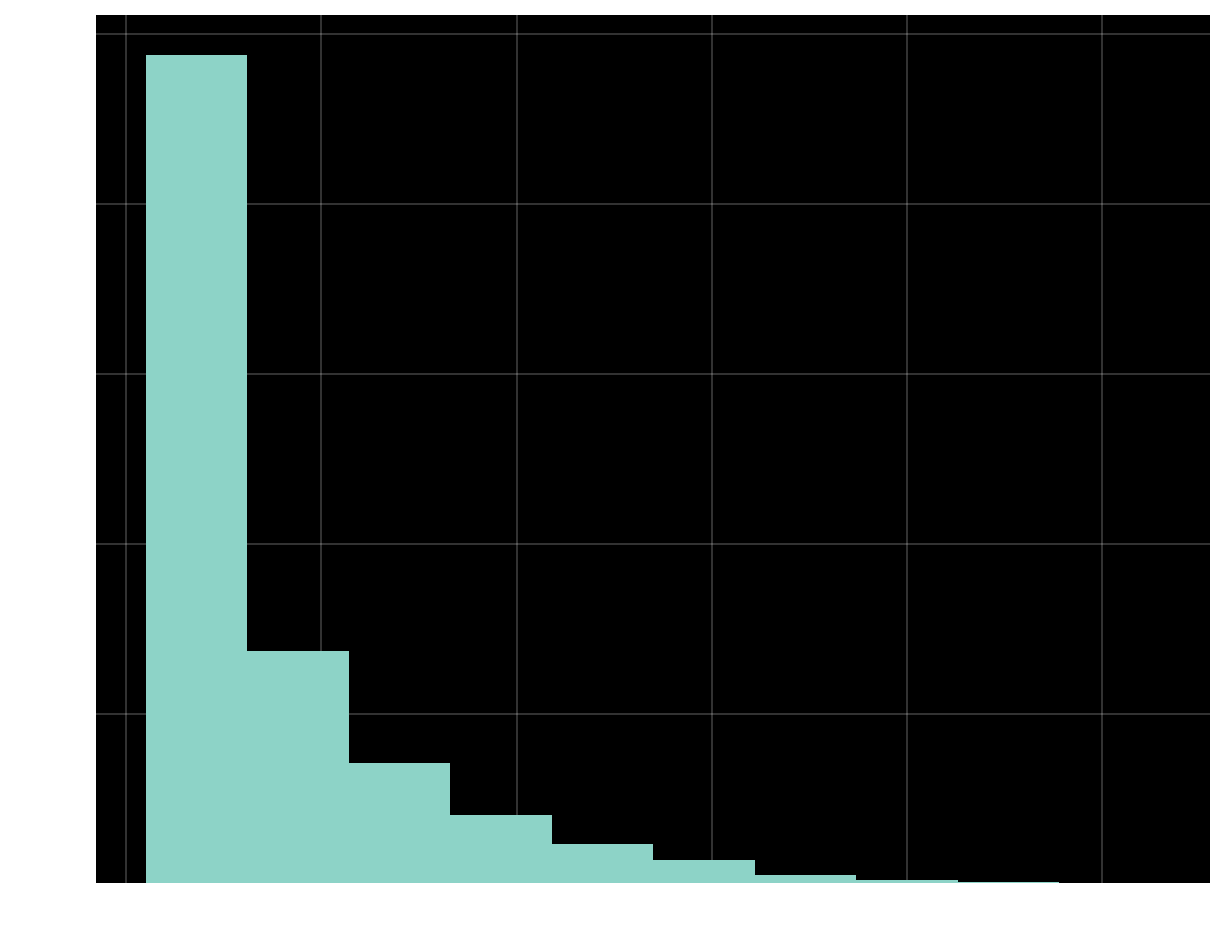

In [60]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [32]:
y_train = df_train['Sentiment']

#### Data nees to be tokenizer for computer to understand. Only the most common num_words will be kept by specifying max_words as num_words. The tokens are then vectorized: map to integers. 0 is a reserved index that won't be assigned to any word. pad_sequences ensure all the phrases are the same length. Shorter sequences will be padded with value (0 by default) at the end. to_categorical(y_train): encoding data.




In [36]:
max_words = 8192

tokenizer = Tokenizer(num_words = max_words,
                     filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_phrase_len)
y_train = to_categorical(y_train)

In [40]:
y_train.shape

(156060, 5)

In [43]:
batch_size = 512
epochs = 8


#### build LSTM model

In [45]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=max_words, output_dim=256, 
                         input_length=max_phrase_len))

model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation='softmax'))

model_lstm.compile(
loss = 'categorical_crossentropy',
optimizer = 'Adam',
metrics=['accuracy']
)

In [46]:
history = model_lstm.fit(X_train, y_train, validation_split=0.1,
                        epochs=8, batch_size=512)

/home/cdsw/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 147s 1ms/step - loss: 1.0613 - accuracy: 0.5779 - val_loss: 1.0172 - val_accuracy: 0.5904
Epoch 2/8
140454/140454 [==============================] - 147s 1ms/step - loss: 0.8547 - accuracy: 0.6570 - val_loss: 0.9907 - val_accuracy: 0.6012
Epoch 3/8
140454/140454 [==============================] - 148s 1ms/step - loss: 0.8043 - accuracy: 0.6757 - val_loss: 1.0172 - val_accuracy: 0.6062
Epoch 4/8
140454/140454 [==============================] - 148s 1ms/step - loss: 0.7734 - accuracy: 0.6857 - val_loss: 1.0140 - val_accuracy: 0.6059
Epoch 5/8
140454/140454 [==============================] - 146s 1ms/step - loss: 0.7483 - accuracy: 0.6948 - val_loss: 1.0327 - val_accuracy: 0.6040
Epoch 6/8
140454/140454 [==============================] - 146s 1ms/step - loss: 0.7272 - accuracy: 0.7010 - val_loss: 1.0431 - val_accuracy: 0.6031
Epoch 7/8
140454/140454 [==============================

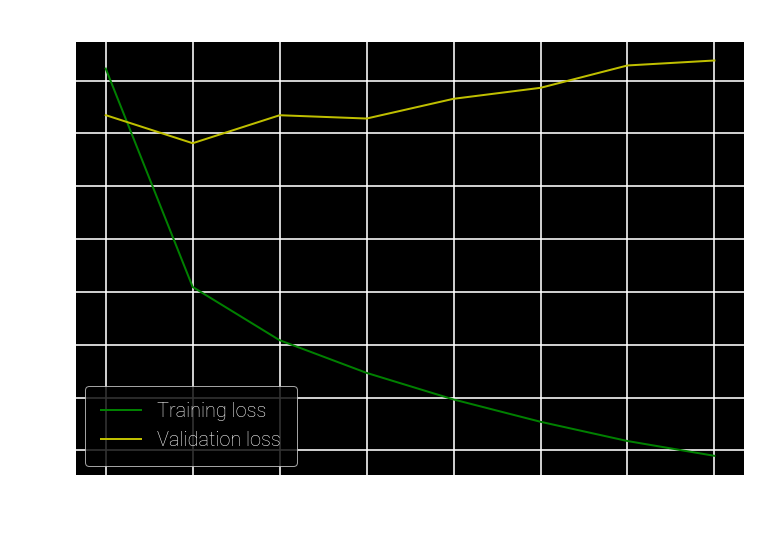

In [47]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

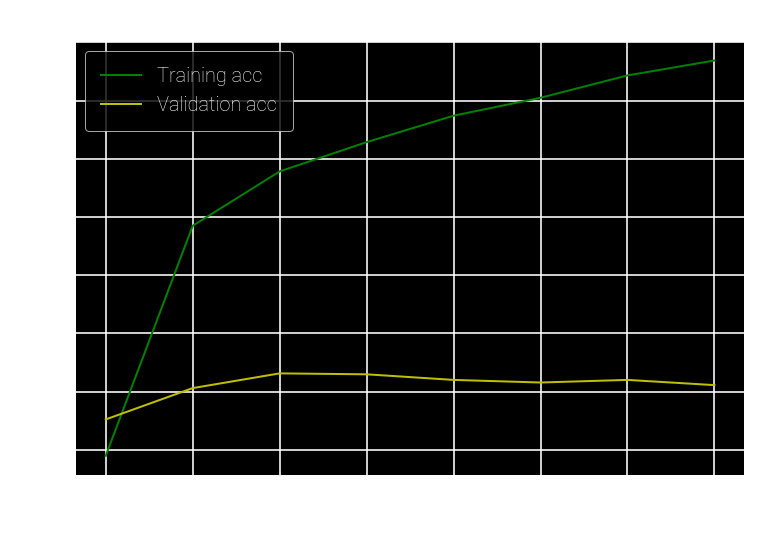

In [54]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()